## Introduction

<font face = "Tahoma" size = 3> Post the 2008 housing crisis and it's global effects housing in Australia has seen a higher rise in prices comparable to the wage growth. House prices were seven times average annual income in late 2000s compared to three times in 1980s. Key reasons for this effect were :
1. Greater availability of credit
2. Low interest rates since 2008
3. Limited release of new land by the government etc.

Given the rise in house pricing increased so fast, some economists have a theory that the Australian property market, especially in cities like Melbourne is significantly overpriced and due for a downturn (price correction)
In this project, we'll try to understand this effect in detail with visualizations and modeling prices against covariates that might effect house prices. We can try to answer the following questions - which sectors are the most expensive vs relatively reasonably priced, how have the prices changed in recent years, is there any seasonality associated with sales of housing units etc.


## Data Exploration

Load libraries

In [123]:
# Import libraries

#Pre-processing
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Magic
%pylab inline

#Custom options
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)
# Set default font size
plt.rcParams['font.size'] = 24
# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
#Sns plots options
sns.set(font_scale = 1)
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Read in the datafile

In [124]:
data = pd.read_csv("Melbourne_housing_FULL.csv")
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [125]:
data.shape

(34857, 21)

Explore data - #unique counts, NaNs etc.

In [153]:
data.apply(lambda x : x.nunique())

Suburb             351
Address          34009
Rooms               12
Type                 3
Price             2871
Method               9
SellerG            388
Date                78
Distance           215
Postcode           211
Bedroom2            15
Bathroom            11
Car                 15
Landsize          1684
BuildingArea       740
YearBuilt          160
CouncilArea         33
Lattitude        13402
Longtitude       14524
Regionname           8
Propertycount      342
dtype: int64

In [170]:
missing_df = data.apply(lambda x : [x.isnull().sum()/len(x)]).T.rename(columns = {0:'% Sparsity'})
missing_df

,% Sparsity
Suburb,0.000000
Address,0.000000
Rooms,0.000000
Type,0.000000
Price,0.218321
Method,0.000000
SellerG,0.000000
Date,0.000000
Distance,0.000029
Postcode,0.000029


<font face="Tahoma" size=3>We have data of 351 suburbs of Melbourne across 8 regions and 211 postal codes. For 21% (~7.6k) we do not have the price information. We intend to remove them from our analysis given we want to model price with other independent variables in this exercise. We have latitude and longitude for a sizable amount of the data, which should ideally be a great predictor under the assumption that prices for properties near to each other should be similar.

We see BuildingArea and YearBuilt have more than 50% Null values, which means they probably might not be able to explain much of the variance in house pricing from a modeling perspective. We remove them on this premise.

In [173]:
#Remove sparse columns
missing_columns = list(missing_df[missing_df['% Sparsity'] > 0.50].index)
print('We will remove %d columns.' % len(missing_columns))


We will remove 2 columns.


In [174]:
# Drop the columns
data_2 = data_2.drop(columns = list(missing_columns))

In [175]:
#Drop data where price is NA
data_2 = data[data['Price'].notnull()]
data_2.shape

(27247, 21)

In [176]:
data_2[['Suburb','Postcode']].apply(lambda x : x.nunique())

Suburb      345
Postcode    209
dtype: int64

<font face="Tahoma" size=3>Upon removing missing pricing information we have data across 345 suburbs and 209 postal codes.

In [177]:
data_2.apply(lambda x : x.isnull().sum()/len(x))[10:21]

Bedroom2         0.236393
Bathroom         0.236613
Car              0.250450
Landsize         0.340037
BuildingArea     0.608911
YearBuilt        0.556502
CouncilArea      0.000110
Lattitude        0.229530
Longtitude       0.229530
Regionname       0.000110
Propertycount    0.000110
dtype: float64

Missing values in updated dataset

In [178]:
data_2.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,27247.0,2.992293e+00,0.954795,1.00000,2.0000,3.00000,4.000000e+00,1.600000e+01
Price,27247.0,1.050173e+06,641467.130105,85000.00000,635000.0000,870000.00000,1.295000e+06,1.120000e+07
Distance,27246.0,1.128028e+01,6.787469,0.00000,6.4000,10.50000,1.400000e+01,4.810000e+01
Postcode,27246.0,3.113796e+03,111.139676,3000.00000,3046.0000,3088.00000,3.153000e+03,3.978000e+03
Bedroom2,20806.0,3.046237e+00,0.955122,0.00000,2.0000,3.00000,4.000000e+00,2.000000e+01
Bathroom,20800.0,1.591683e+00,0.700880,0.00000,1.0000,1.00000,2.000000e+00,9.000000e+00
Car,20423.0,1.715370e+00,0.994216,0.00000,1.0000,2.00000,2.000000e+00,1.800000e+01
Landsize,17982.0,5.934889e+02,3757.266429,0.00000,219.0000,512.00000,6.640000e+02,4.330140e+05
BuildingArea,10656.0,1.568346e+02,449.222791,0.00000,100.0000,133.00000,1.820000e+02,4.451500e+04
YearBuilt,12084.0,1.966609e+03,36.762373,1196.00000,1950.0000,1970.00000,2.000000e+03,2.019000e+03


Univariate EDA - Number of Rooms

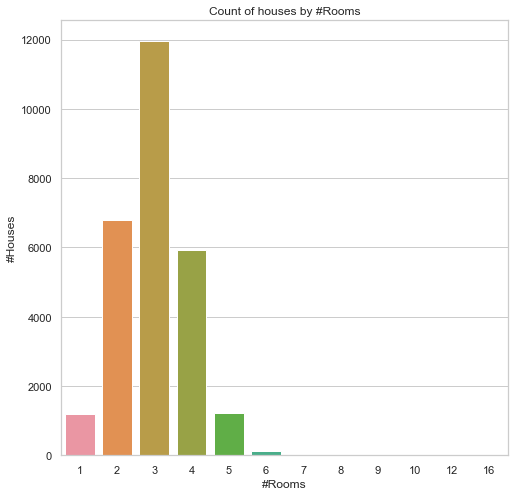

In [179]:
sns.countplot(x='Rooms', data=data_2)

plt.title('Count of houses by #Rooms')
plt.xlabel('#Rooms')
plt.ylabel('#Houses')
plt.show();

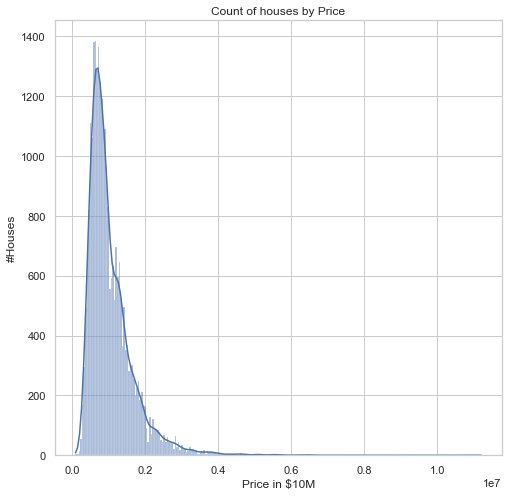

In [180]:
sns.histplot(x='Price', data=data_2 , kde = True)

plt.title('Count of houses by Price')
plt.xlabel('Price in $10M')
plt.ylabel('#Houses')
plt.show();

In [181]:
#Price by 95th percentile 
quantile(data_2['Price'],0.9)

1800000.0

In [182]:
data_2[data_2['Price'] > quantile(data_2['Price'],0.9)].shape

(2697, 21)

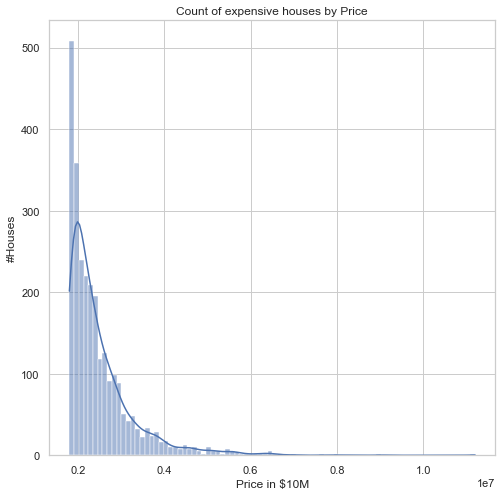

In [183]:
sns.histplot(x='Price', data=data_2[data_2['Price']>quantile(data_2['Price'],0.9)] , kde = True)

plt.title('Count of expensive houses by Price')
plt.xlabel('Price in $10M')
plt.ylabel('#Houses')
plt.show();

Distribution is highly right skewed. We may need different model to predict higher end houses. We subset houses priced more than $1.8M into a separate dataframe and can model these prices separately. The idea is to validate, for houses with higher price prediction from full data model, whether the subsetted data model provides significant lift in accuracy. We see 2,697 such houses which should be a sizable number to test this hypothesis.

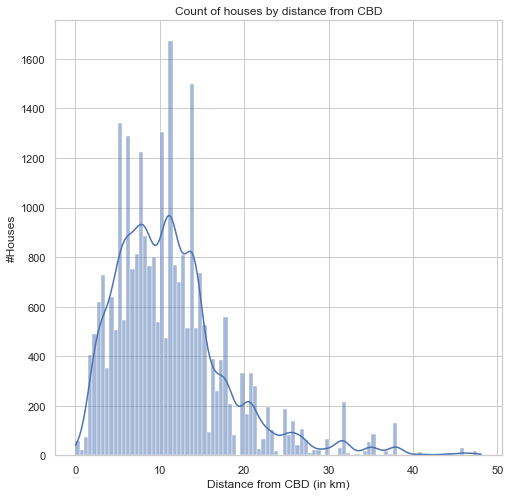

In [184]:
sns.histplot(x='Distance', data=data_2 , kde = True)

plt.title('Count of houses by distance from CBD')
plt.xlabel('Distance from CBD (in km)')
plt.ylabel('#Houses')
plt.show();

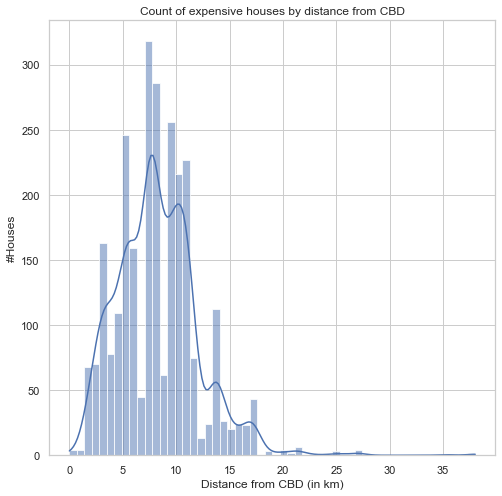

In [185]:
sns.histplot(x='Distance', data=data_2[data_2['Price']>quantile(data_2['Price'],0.9)] , kde = True)

plt.title('Count of expensive houses by distance from CBD')
plt.xlabel('Distance from CBD (in km)')
plt.ylabel('#Houses')
plt.show();

Most of the houses are based within 5-15 km radius from the Central Business District. Our sample of high priced houses also shows similar distribution. Key insight is almost no houses priced more than $1.8M are outside the 20km radius from CBD.

In [186]:
data_2['Suburb'].value_counts()[0:10]

Reservoir         727
Bentleigh East    493
Richmond          439
Preston           415
Brunswick         387
Essendon          361
Northcote         345
Glenroy           342
South Yarra       328
Glen Iris         323
Name: Suburb, dtype: int64

Text(0.5, 1.03, '#Houses sold by suburb for properties over $4M')

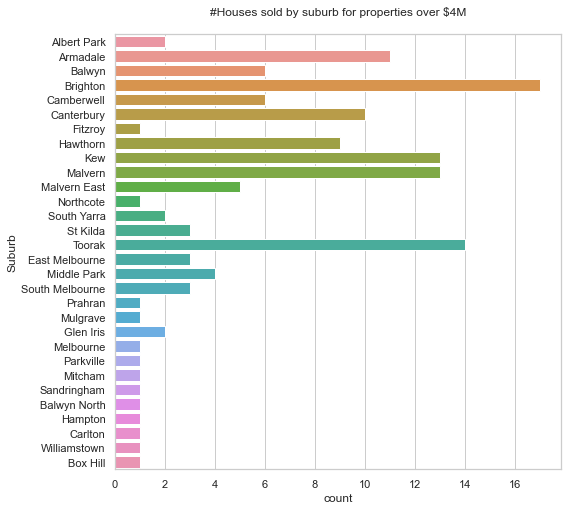

In [187]:
sns.countplot(data=data_2[data_2['Price']>quantile(data_2['Price'],0.995)], y='Suburb')
plt.title("#Houses sold by suburb for properties over $4M", y=1.03)

We see there are popular suburbs with most houses sold as well as few suburbs with few and expensive houses sold. If we do not want to pass information of all 345 suburbs, we atleast need to include these few suburbs information to provide pertinent information to regression model.

<AxesSubplot:xlabel='Type', ylabel='count'>

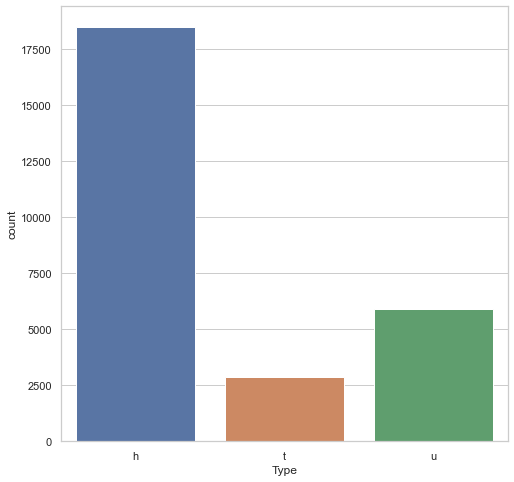

In [188]:
sns.countplot(x='Type', data=data_2)

We see more houses than townhouses and units! We start further checking if all variables in data pass the basic sense check

,Landsize
28694,40469.0
32220,40500.0
8599,41400.0
34055,42800.0
22632,44500.0
1198,75100.0
17293,76000.0
24800,89030.0
26868,146699.0
18036,433014.0


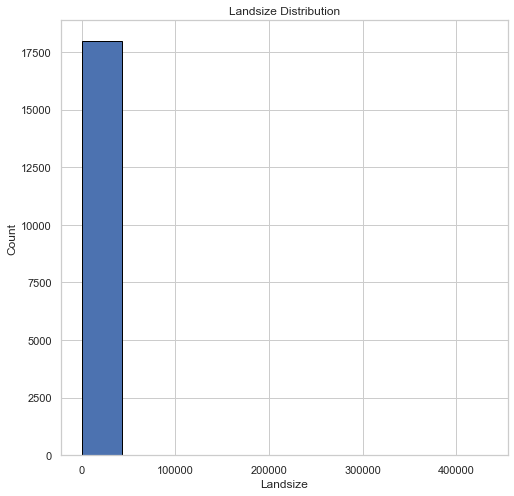

In [189]:
# Histogram Plot of Landsize
figsize(8,8)
plt.hist(data_2['Landsize'].dropna(), bins = 10, edgecolor = 'black');
plt.xlabel('Landsize');
plt.ylabel('Count'); plt.title('Landsize Distribution');

#data_2["Landsize"].describe()

data_2[["Landsize"]].dropna().sort_values(by = 'Landsize').tail(10)

#data_2.loc[data_2["Landsize"] == 433014]


We see for landsize we have too many outliers which do not seem to be realistic sizes for a house. For example, the highest landsize goes upto 433014 sq meters analogous to the size of Vatican city, the smallest country in the world. Such a house (with 3 rooms) is definitely incorrect data entry. We start cleaning our data of such unfeasible records.

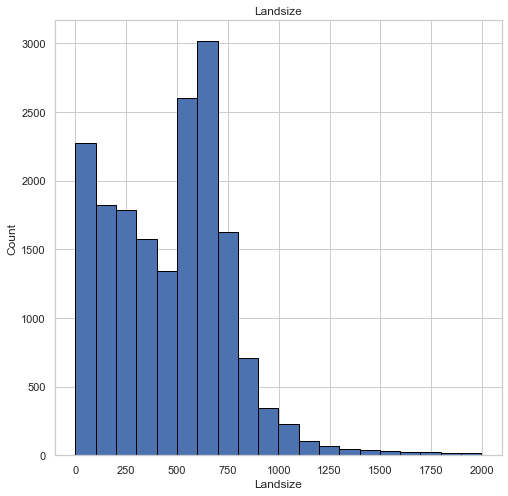

In [190]:
first_quartile = data_2["Landsize"].describe()['25%']
third_quartile = data_2["Landsize"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
data_2 = data_2[(data_2["Landsize"] > (first_quartile - 3 * iqr)) &
            (data_2["Landsize"] < (third_quartile + 3 * iqr))]
figsize(8, 8)
plt.hist(data_2["Landsize"].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Landsize');
plt.ylabel('Count'); plt.title('Landsize');

We opt for a less aggresive outlier removal and drop a record if landsize ditribution lies in the range of (*1st quartile - 3\*IQR* to *3rd quartile + 3\*IQR*)

Revisiting all continuous variables distributions for the cleaned dataframe

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Distance'}>,
        <AxesSubplot:title={'center':'Postcode'}>],
       [<AxesSubplot:title={'center':'Bedroom2'}>,
        <AxesSubplot:title={'center':'Bathroom'}>,
        <AxesSubplot:title={'center':'Car'}>,
        <AxesSubplot:title={'center':'Landsize'}>],
       [<AxesSubplot:title={'center':'BuildingArea'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'Lattitude'}>,
        <AxesSubplot:title={'center':'Longtitude'}>],
       [<AxesSubplot:title={'center':'Propertycount'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

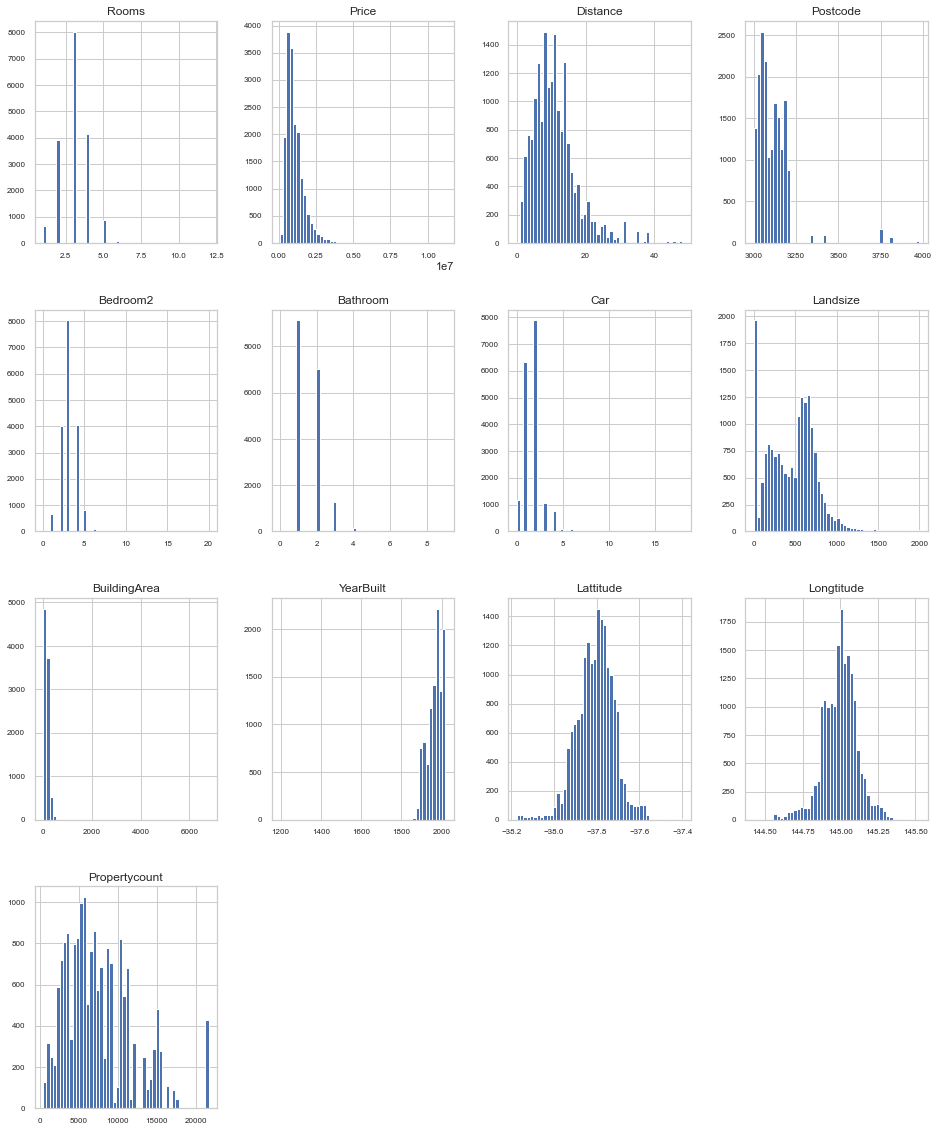

In [150]:
data_2.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

Bivariate EDA and Correlation

<AxesSubplot:>

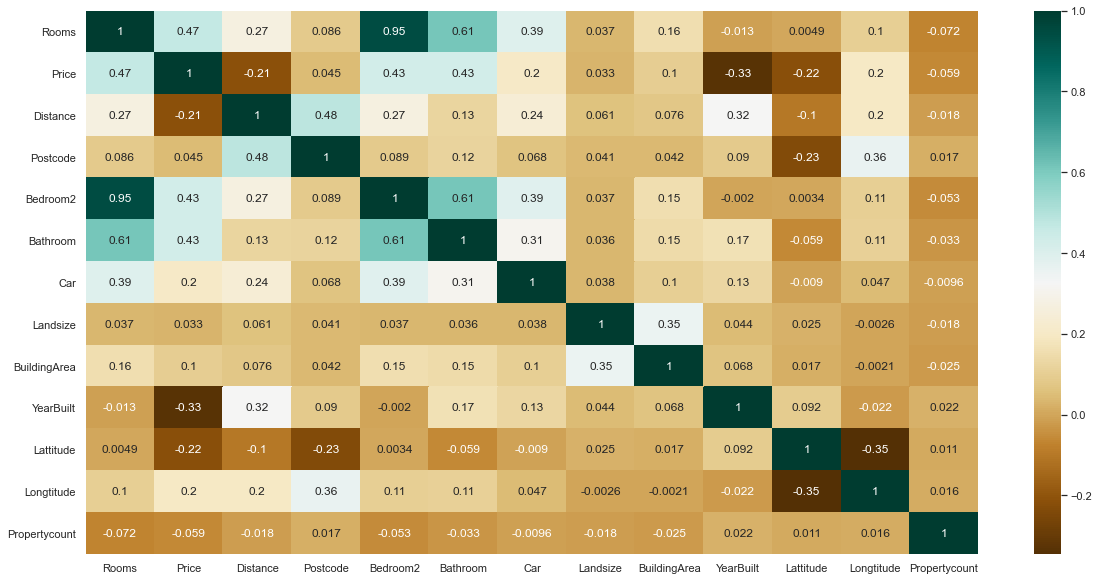

In [191]:
plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)


### Is the housing market cooling off? If so, when exactly did it happen

### What variables contributed to the cool off

### Is the housing market cooling off? If so, when exactly did it happen

### Is the housing market cooling off? If so, when exactly did it happen